# Computer Vision - Assignment 3

## 2. Perform Intensity Window-based correlation on the same set of images

In [25]:
import cv2
import numpy as np
from skimage import filters
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_blocks
from scipy.spatial.distance import cdist
from scipy.ndimage.filters import convolve
from skimage.feature import corner_peaks
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 12.0)  # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

**Stereo Correspondence**

Objective is to find the (corresponding) points X_l and X_r in the two images that are projections of the same 3D point X. 

The horizontal shift of the point is called  **disparity**
All methods attempt to match pixels in one image with pixels in the other image by exploiting a number of constraints.
1. Local methods: use constraints on a small numer of pixels surrounding the pixel of interest.

   • Block matching/Window Based - 
   
        • Correlation (NCC)
        • Intensity difference (SAD, SSD)
        • Rank (rank transform, census transform)

2. Global methods: use constraints on scan-lines or the whole image.

       • Dynamic programming
       • Graph cuts

Window based correletaion is computing disparity using NCC


![alt text](cv3\ncc.png "NCC")

![alt text](cv3\ncc2.png "NCC")

**Helper functions**

In [26]:

def getColorSpaces(image):  
    rgb = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)  
    
    return rgb,gray
    
def getImageDimnesion(image):    
    height,width = image.shape[:2]
    
    return height,width

def showImage(image,title):    
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title(title)
      
def getSubImage(img,left,right,top,bottom):
    
    return img[top:bottom, left:right].astype(np.float32)

Block matching searches one image for the best corresponding region for a template in the other image.

Function to compute Normalized Cross Correlation(NCC)

In [27]:
def getNCC(windowL,windowR):
    
    #A solution is to NORMALIZE the pixels in the windows 
    #before comparing them by subtracting the mean of the of the
    #patch intensities and dividing by the std.dev std.dev.  
    windowL_Mean_Substract=windowL - np.mean(windowL)
    windowL_Standard_deviation= np.sqrt(np.sum(np.square(windowL_Mean_Substract)))
    
    windowR_Mean_Substract=windowL - np.mean(windowR)
    windowR_Standard_deviation= np.sqrt(np.sum(np.square(windowR_Mean_Substract)))
    
    numerator= windowL_Mean_Substract*windowR_Mean_Substract
    denominator=windowL_Standard_deviation*windowR_Standard_deviation
    
    ncc=np.sum(numerator/denominator)
    
    return ncc

Finds the maximum correlation between Left block(template) and right strip (row_dest) -OpenCV implementation

In [28]:
def getMaxNCC(right_strip, template):
    res = cv2.matchTemplate(right_strip, template, cv2.TM_CCOEFF_NORMED)
    max_sim = np.argmax(res)
    return max_sim


Finds the maximum correlation location between Left block(template) and right strip (row_dest) -Python implementation

In [29]:
def getMatchingLocation(template,Right_strip):
    template_H,template_W=template.shape[:2]
    strip_H,strip_W=Right_strip.shape[:2]

    corr_list=[]
    for i in range (0,strip_W-template_W):
        right_block=getSubImage(Right_strip,i,i+template_W,0,strip_H)
        corr=getNCC(template,right_block)
        corr_list.append((corr,i))
    sorted_corr=sorted(corr_list,key=lambda x:x[1],reverse=True)
    return sorted_corr[0][1]

Computer Disparity between stereo pair using NCC

Uncomment the lines for Python implementation --Very Slow ! Terribly Slow !

In [30]:
def getDisparity_NCC(LeftImage,RightImage,block_size=7,disparity_range=30):

    height,width= getImageDimnesion(LeftImage)
    disparity_image = np.zeros(LeftImage.shape, dtype=np.float32)
    halfBlockSize=int(block_size/2) 

    for row in range(halfBlockSize, height-halfBlockSize):
        print(".", end="", flush=True) 
        template_row_min  = int(max(row-halfBlockSize, 0)) 
        template_row_max =  int(min(row+halfBlockSize+1, height))
        
        for col in range(halfBlockSize, width-halfBlockSize):
#            best_offset = 0
#            max_ncc = 0.0
            # get template
            template_col_min = int(max(col-halfBlockSize, 0))
            template_col_max = int(min(col+halfBlockSize+1, width))
            template =  getSubImage(LeftImage,template_col_min,template_col_max,template_row_min,template_row_max)

            # get row strip in a window with width=disparity_range
            strip_col_min = int(max(col-disparity_range/2, 0))
            strip_col_max = int(min(col+disparity_range/2+1, width))
            
            Right_strip = getSubImage(RightImage,strip_col_min,strip_col_max,template_row_min,template_row_max)
#            strip_H,strip_W=Right_strip.shape[:2]
#            template_H,template_W=template.shape[:2]
#            
#            for offset in range (0,strip_W-template_W):
#                right_block=getSubImage(Right_strip,offset,offset+template_W,0,strip_H)                 
#                ncc=getMaxNCC(template,right_block)                
#                if (max_ncc < ncc):
#                    max_ncc = ncc
#                    best_offset = offset
#                
            
            res = cv2.matchTemplate(Right_strip, template, method=cv2.TM_CCORR_NORMED) 
            template_col = int(max(col-strip_col_min-halfBlockSize, 0))
            diff = np.arange(res.shape[1]) - template_col
            match_loc =np.argmax(res)
            disparity_image[row, col] = diff[match_loc]
#            disparity_image[row, col] = best_offset
            #matchPixels.append([row,col,row,match_loc])

    return disparity_image  

In [31]:
# Read the images
img = cv2.imread(r'Stereo Images\Stereo_Pair1.jpg')

height,width = img.shape[:2]
width_cutoff = width // 2
imgL = img[:, :width_cutoff]
imgR = img[:, width_cutoff:]


Original Images

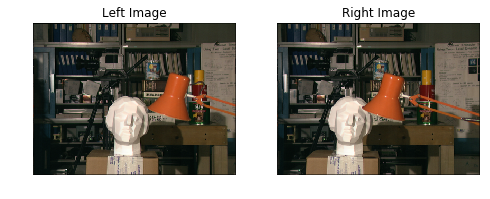

In [32]:
#imgL=cv2.imread(r'Stereo Images\tsucuba_left.png')
#imgR=cv2.imread(r'Stereo Images\tsucuba_right.png')

rgbL,grayL=getColorSpaces(imgL)
rgbR,grayR=getColorSpaces(imgR)

#Display the images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
showImage(rgbL,'Left Image')
plt.subplot(1,2,2)
showImage(rgbR,'Right Image')
plt.show()

Disparity Map

..................................................................................................................................................................................................................................................................................

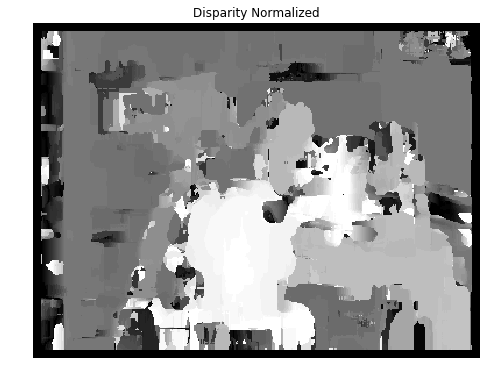

In [33]:

grayL = grayL * (1.0 / 255.0)
grayR = grayR * (1.0 / 255.0)

#Filter window size
block_size=15

disparity_range=100  

disp = np.abs(getDisparity_NCC(grayL, grayR, block_size, disparity_range))
# Scale disparity image
disp_norm = cv2.normalize(disp, disp, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.figure(figsize=(8,8))
showImage(disp_norm,'Disparity Normalized')
plt.show()


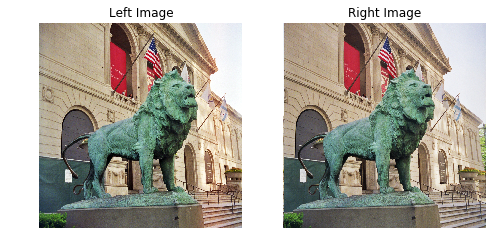

In [34]:
img = cv2.imread(r'Stereo Images\Stereo_Pair1.jpg')

height,width = img.shape[:2]
width_cutoff = width // 2
imgL = img[:, :width_cutoff]
imgR = img[:, width_cutoff:]
rgbL,grayL=getColorSpaces(imgL)
rgbR,grayR=getColorSpaces(imgR)

#Display the images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
showImage(rgbL,'Left Image')
plt.subplot(1,2,2)
showImage(rgbR,'Right Image')
plt.show()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

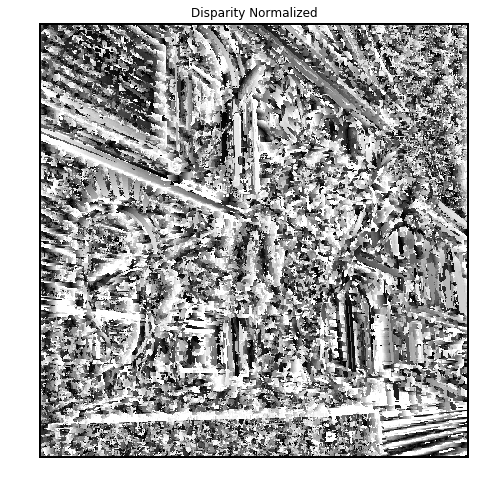

In [35]:
grayL = grayL * (1.0 / 255.0)
grayR = grayR * (1.0 / 255.0)

#Filter window size
block_size=15

disparity_range=100  

disp = np.abs(getDisparity_NCC(grayL, grayR, block_size, disparity_range))
# Scale disparity image
disp_norm = cv2.normalize(disp, disp, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.figure(figsize=(8,8))
showImage(disp_norm,'Disparity Normalized')
plt.show()